## Compare ECCO and ERA5 net air-sea heat fluxes

In [6]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import cmocean
import matplotlib.pyplot as plt

Open ECCO heat flux data

In [7]:
# define root directory for location of all downloaded NetCDF files
root_dir = Path('../data/ECCO_V4r4_PODAAC')

# define the directory where the files specific to desired dataset are stored
nc_heat_dir = root_dir / "ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4"

In [8]:
# get all files in each folder for import
heat_nc_files = list(nc_heat_dir.glob('*nc'))

In [9]:
# import 26 years of ecco heat flux data
heat_ds = xr.open_mfdataset(heat_nc_files, parallel=True, data_vars='minimal',\
                            coords='minimal', compat='override')

heat_ds

<xarray.Dataset>
Dimensions:         (time: 312, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T...
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    EXFhl           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFhs           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFlwdn         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFswdn         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFqnet         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    oceQnet         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SIatmQnt        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    TFLUX           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFswnet        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFlwnet        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    oceQsw          (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SIaaflux        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Ocean and Sea-Ice Surface Heat Fluxes ...
    uuid:                         73ea7d5c-4158-11eb-8d61-0cc47a3f812d

In [16]:
# isolate data for the western Labrador Sea
heat_Lab = heat_ds.sel(longitude=slice(-60,-51), latitude=slice(57,62))

In [25]:
# loop through each winter season and take the mean
years = list(range(1992, 2017, 1))
months = list(range(1,13,1))
months *= 2
ecco_winter_heat = pd.DataFrame({"start_year": years})
heat = []

for year in years:
    # subset 2 years of data from which winter months will be isolated
    data_tmp = heat_Lab.SIatmQnt.sel(time=slice(str(year),str(year+1)))
    # change time values to months (numerical)
    data_tmp['time'] = months
    # take winter months and average across them
    tmp = data_tmp.isel(time=data_tmp.time.isin([11,12,1,2,3])).mean(dim=['time','latitude','longitude'])
    # assign to final output
    heat.append(tmp.values)
ecco_winter_heat['heat_flux'] = heat
print(ecco_winter_heat)

    start_year  heat_flux
0         1992   210.9501
1         1993  206.53302
2         1994  237.04105
3         1995  206.86719
4         1996  191.54181
5         1997  237.66591
6         1998  247.57565
7         1999   245.5509
8         2000  244.83635
9         2001   265.7025
10        2002  261.26935
11        2003  263.17432
12        2004  285.44183
13        2005  266.14935
14        2006  240.73297
15        2007   247.7718
16        2008  232.95955
17        2009  162.44896
18        2010  198.53209
19        2011  266.05768
20        2012  236.86089
21        2013  231.24272
22        2014   283.9493
23        2015   287.4732
24        2016  255.26486


Open ERA5 heat flux data

In [11]:
# inlcudes 1979-2021 variables: Surface net solar radiation, Surface net thermal radiation
solar_thermal = xr.load_dataset("../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_solar_thermal_heat.grib", engine='cfgrib')

Ignoring index file '../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_solar_thermal_heat.grib.923a8.idx' incompatible with GRIB file


In [12]:
# inlcudes 1979-2021 variables: Surface latent heat flux, Surface sensible heat flux
latent_sensible = xr.load_dataset("../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_latent_sensible_heat.grib", engine='cfgrib')

Ignoring index file '../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_latent_sensible_heat.grib.923a8.idx' incompatible with GRIB file


In [13]:
# The units are joules per square metre (J m^-2 ). 
# To convert to watts per square metre (W m^-2 ), the accumulated values should be divided by the accumulation period expressed in seconds.
# must divide values by 86,400 (sec/day)
Q_net = (solar_thermal.ssr/86400 + solar_thermal.str/86400 + latent_sensible.slhf/86400 + latent_sensible.sshf/86400)*(-1)

In [24]:
Q_net_Lab = Q_net.sel(time=slice("1992","2017"),longitude=slice(-60,-51),latitude=slice(62,57))

In [26]:
# loop through each winter season and take the mean
years = list(range(1992, 2017, 1))
months = list(range(1,13,1))
months *= 2
era5_winter_heat = pd.DataFrame({"start_year": years})
heat = []

for year in years:
    # subset 2 years of data from which winter months will be isolated
    data_tmp = Q_net_Lab.sel(time=slice(str(year),str(year+1)))
    # change time values to months (numerical)
    data_tmp['time'] = months
    # take winter months and average across them
    tmp = data_tmp.isel(time=data_tmp.time.isin([11,12,1,2,3])).mean(dim=['time','latitude','longitude'])
    # assign to final output
    heat.append(tmp.values)
era5_winter_heat['heat_flux'] = heat
print(era5_winter_heat)

    start_year           heat_flux
0         1992  234.38157863704478
1         1993  219.68342197070584
2         1994   235.7873880033307
3         1995  202.87580495972165
4         1996  216.83580716356238
5         1997  254.55376250059584
6         1998  211.88414968465491
7         1999  186.66428205288625
8         2000  196.50549474623435
9         2001  212.81780013793556
10        2002  234.50128298275953
11        2003   257.6611877789248
12        2004   238.1588431876817
13        2005  184.24785457853685
14        2006  197.64557332108893
15        2007  222.42784544142356
16        2008  194.03261987359383
17        2009  145.69163684890248
18        2010  206.29554327094954
19        2011  244.49633016573122
20        2012  198.44953904574217
21        2013   235.9963007345143
22        2014   265.8498169493899
23        2015  240.49818767167466
24        2016  228.42248026486305


Compare ERA5 and ECCO winter heat fluxes

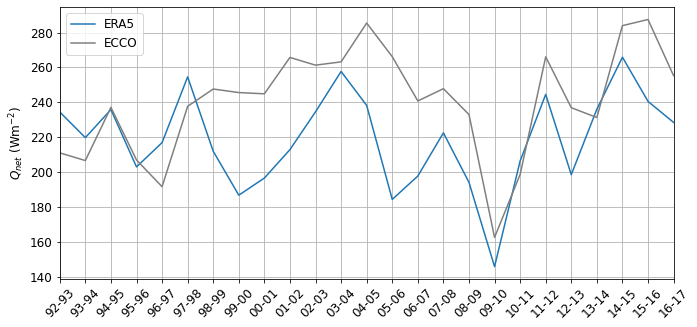

In [31]:
plt.figure(figsize=[11, 5])
plt.rcParams['font.size'] = '12'

plt.plot(era5_winter_heat.start_year,era5_winter_heat.heat_flux,color='tab:blue',label='ERA5')
plt.plot(ecco_winter_heat.start_year,ecco_winter_heat.heat_flux,color='tab:gray',label='ECCO')

# ticks
year_span = []
for year in winter_heat.start_year:
    year_span.append(str(year)[-2:]+'-'+str(year+1)[-2:])

plt.margins(x=0)
plt.ylabel("$Q_{net}$ (Wm$^{-2}$)")
plt.xticks(ticks=era5_winter_heat.start_year, labels=year_span, rotation=45)

plt.legend()
plt.grid();